# Semi-Supervised Architope (Financial Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 50

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .2
N = 1000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  1000


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [7]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [8]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print((N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
#                 y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Apply Random Partitioner to the given Dataset

In [9]:
import time
partitioning_time_begin = time.time()

In [10]:
if Option_Function == 'SnP':
    q_in_auto = .8
    Min_data_size_percentage_auto = .1
    min_size_part = 100
else:
    if Option_Function == 'crypto':
        q_in_auto = .99
        Min_data_size_percentage_auto = .3
        min_size_part = 100
    if Option_Function == 'Motivational_Example':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 20
        # Partition Based on Y
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
    else:
        q_in_auto = .5
        Min_data_size_percentage_auto = .3
        min_size_part = 100

In [11]:
# Initialize Number of Parts currently generated
N_parts_generated = 0

# Generate Partition (with option to regernerate if only 1 part is randomly produced)
while N_parts_generated < 2:
    # Generate Parts
    X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                      q_in=q_in_auto, 
                                                                      X_train_in=X_train, 
                                                                      y_train_in=data_y, 
                                                                      CV_folds_failsafe=CV_folds,
                                                                      min_size = min_size_part)
    
    # Update Number of Parts
    N_parts_generated = len(X_parts_list)
    # Shuffle hyperparameters
    Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
    q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1
    
    # Update User
    print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')
    
# Trash removal (removes empty parts)
X_parts_list = list(filter(([]).__ne__, X_parts_list))
y_parts_list = list(filter(([]).__ne__, y_parts_list))
    
    
# ICML Rebuttle Deadline = Coersion!
if Option_Function == 'Motivational_Example':
    # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
    holder_temp = data_y
    data_y = X_train
    X_train = holder_temp
    holder_temp = y_parts_list
    y_parts_list = X_parts_list
    X_parts_list = holder_temp

0.659
0.454
0.302
0.178
0.028
0.0
The_parts_listhe number of parts are: 7.


In [12]:
partitioning_time = time.time() - partitioning_time_begin

In [13]:
print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

The_parts_listhe number of parts are: 6.


#### Building Training Predictions on each part
- Train locally (on each "naive part")
- Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
- Generate predictions on all of testing-set (will be selected between later using classifier)

In [14]:
# Time-Elapse (Start) for Training on Each Part
Architope_partition_training_begin = time.time()
# Initialize running max for Parallel time
Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
# Initialize N_parameter counter for Architope
N_params_Architope = 0

In [25]:
# Silly Coercsion for ICML rebuttle deadline timeline
if Option_Function == 'Motivational_Example':
    Iteration_Length = len(X_parts_list) -1
else:
    Iteration_Length = len(X_parts_list)

    
# Train each part!
for current_part in range(Iteration_Length):
    #==============#
    # Timer(begin) #
    #==============#
    current_part_training_time_for_parallel_begin = time.time()
    
    
    # Initializations #
    #-----------------#
    # Reload Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Modify heights according to optimal (data-driven) rule (with threshold)
    current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
    current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
    current_height = np.maximum(current_height,current_height_threshold)
    current_height = current_height.astype(int).tolist()
    param_grid_Vanilla_Nets['height'] = current_height
    # Automatically Fix Input Dimension
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
    param_grid_Vanilla_Nets['output_dim'] = [1]
    
    # Update User #
    #-------------#
    print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
    print('Heights to iterate over: '+str(current_height))
    
    # Generate Prediction(s) on current Part #
    #----------------------------------------#
    # Failsafe (number of data-points)
    CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
    # Train Network
    y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                     n_jobs = n_jobs,
                                                                                     n_iter = n_iter, 
                                                                                     param_grid_in = param_grid_Vanilla_Nets, 
                                                                                     X_train= X_parts_list[current_part], 
                                                                                     y_train=y_parts_list[current_part],
                                                                                     X_test_partial=X_train,
                                                                                     X_test=X_test)
    
    # Append predictions to data-frames
    ## If first prediction we initialize data-frames
    if current_part==0:
        # Register quality
        training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
        training_quality = training_quality.reshape(training_quality.shape[0],1)

        # Save Predictions
        predictions_train = y_hat_train_full_loop
        predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
        predictions_test = y_hat_test_full_loop
        predictions_test = predictions_test.reshape(predictions_test.shape[0],1)
        
        
    ## If not first prediction we append to already initialized dataframes
    else:
    # Register Best Scores
        #----------------------#
        # Write Predictions 
        # Save Predictions
        y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],1)
        predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
        y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],1)
        predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)
        
        # Evaluate Errors #
        #-----------------#
        # Training
        prediction_errors = np.abs(y_hat_train_loop.reshape(-1,)-y_train)
        training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)
        
    #============#
    # Timer(end) #
    #============#
    current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
    Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)

    #============---===============#
    # N_parameter Counter (Update) #
    #------------===---------------#
    N_params_Architope = N_params_Architope + N_params_Architope_loop

# Update User
#-------------#
print(' ')
print(' ')
print(' ')
print('----------------------------------------------------')
print('Feature Generation (Learning Phase): Score Generated')
print('----------------------------------------------------')
print(' ')
print(' ')
print(' ')

Status: Current part: 0 out of : 6 parts.
Heights to iterate over: [66]
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.6s finished


Epoch 1/100
22/22 [==============================] - 0s 2ms/step - loss: 0.4950 - mse: 0.6443 - mae: 0.4950 - mape: 3668.1726
Epoch 2/100
22/22 [==============================] - 0s 1ms/step - loss: 0.1467 - mse: 0.0283 - mae: 0.1467 - mape: 977.4575
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.1963 - mse: 0.0568 - mae: 0.1963 - mape: 1474.2837
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.1421 - mse: 0.0294 - mae: 0.1421 - mape: 984.3519
Epoch 5/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0682 - mse: 0.0063 - mae: 0.0682 - mape: 537.5481
Epoch 6/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0463 - mse: 0.0034 - mae: 0.0463 - mape: 347.5682
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0368 - mse: 0.0019 - mae: 0.0368 - mape: 278.5499
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0379 - mse: 0.0021 - mae: 0.0379 - mape: 265.502

22/22 [==============================] - 0s 2ms/step - loss: 0.0327 - mse: 0.0016 - mae: 0.0327 - mape: 266.2002
Epoch 66/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0384 - mse: 0.0020 - mae: 0.0384 - mape: 317.5008
Epoch 67/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0276 - mse: 0.0012 - mae: 0.0276 - mape: 193.4094
Epoch 68/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0143 - mse: 3.2937e-04 - mae: 0.0143 - mape: 133.2447
Epoch 69/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 5.4485e-04 - mae: 0.0174 - mape: 141.8206
Epoch 70/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0166 - mse: 4.3029e-04 - mae: 0.0166 - mape: 126.6364
Epoch 71/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0235 - mse: 7.9597e-04 - mae: 0.0235 - mape: 190.8404
Epoch 72/100
22/22 [==============================] - 0s 1ms/step - loss: 0.0242 - mse: 8.4886e-04 - mae: 0.0242 - 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.8s finished


Epoch 1/100
13/13 [==============================] - 0s 2ms/step - loss: 0.4754 - mse: 0.5242 - mae: 0.4754 - mape: 203.2173
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 0.2530 - mse: 0.0883 - mae: 0.2530 - mape: 105.3694
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0808 - mse: 0.0090 - mae: 0.0808 - mape: 34.6016
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0452 - mse: 0.0032 - mae: 0.0452 - mape: 19.3880
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0573 - mse: 0.0050 - mae: 0.0573 - mape: 25.5278
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0533 - mse: 0.0045 - mae: 0.0533 - mape: 23.9192
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0429 - mse: 0.0028 - mae: 0.0429 - mape: 19.0400
Epoch 8/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0446 - mse: 0.0031 - mae: 0.0446 - mape: 20.3951
Epoch 

13/13 [==============================] - 0s 1ms/step - loss: 0.0339 - mse: 0.0019 - mae: 0.0339 - mape: 15.3093
Epoch 67/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0024 - mae: 0.0387 - mape: 17.3067
Epoch 68/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0248 - mse: 9.5252e-04 - mae: 0.0248 - mape: 11.4147
Epoch 69/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0420 - mse: 0.0028 - mae: 0.0420 - mape: 18.0954
Epoch 70/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0466 - mse: 0.0032 - mae: 0.0466 - mape: 19.4139
Epoch 71/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0421 - mse: 0.0027 - mae: 0.0421 - mape: 17.8989
Epoch 72/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0386 - mse: 0.0024 - mae: 0.0386 - mape: 16.4437
Epoch 73/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0350 - mse: 0.0020 - mae: 0.0350 - mape: 15.7182
Epoch 74/

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.1s finished


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 0.6152 - mse: 0.7393 - mae: 0.6152 - mape: 140.1918
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 0.1238 - mse: 0.0251 - mae: 0.1238 - mape: 27.9439
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0685 - mse: 0.0082 - mae: 0.0685 - mape: 15.4294
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 0.1640 - mse: 0.0353 - mae: 0.1640 - mape: 36.5058
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0807 - mse: 0.0098 - mae: 0.0807 - mape: 18.2913
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0694 - mse: 0.0068 - mae: 0.0694 - mape: 15.4846
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0598 - mse: 0.0054 - mae: 0.0598 - mape: 13.6168
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1051 - mse: 0.0150 - mae: 0.1051 - mape: 23.3963
Epoch 9

10/10 [==============================] - 0s 2ms/step - loss: 0.0521 - mse: 0.0045 - mae: 0.0521 - mape: 11.5233
Epoch 67/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0631 - mse: 0.0056 - mae: 0.0631 - mape: 14.0813
Epoch 68/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0545 - mse: 0.0045 - mae: 0.0545 - mape: 12.1548
Epoch 69/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0691 - mse: 0.0076 - mae: 0.0691 - mape: 15.6946
Epoch 70/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0567 - mse: 0.0049 - mae: 0.0567 - mape: 12.7975
Epoch 71/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0611 - mse: 0.0059 - mae: 0.0611 - mape: 13.8586
Epoch 72/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0840 - mse: 0.0123 - mae: 0.0840 - mape: 18.6111
Epoch 73/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0921 - mse: 0.0130 - mae: 0.0921 - mape: 21.0129
Epoch 74/100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.6s finished


Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 0.7772 - mse: 1.1787 - mae: 0.7772 - mape: 124.0540
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3378 - mse: 0.2092 - mae: 0.3378 - mape: 54.9308
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 0.1919 - mse: 0.0530 - mae: 0.1919 - mape: 30.7811
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1893 - mse: 0.0472 - mae: 0.1893 - mape: 30.3705
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2029 - mse: 0.0556 - mae: 0.2029 - mape: 32.5023
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1813 - mse: 0.0414 - mae: 0.1813 - mape: 29.1335
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1742 - mse: 0.0392 - mae: 0.1742 - mape: 28.1509
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0704 - mse: 0.0074 - mae: 0.0704 - mape: 11.2147
Epoch 9/100
8/8 [======

8/8 [==============================] - 0s 2ms/step - loss: 0.0402 - mse: 0.0031 - mae: 0.0402 - mape: 6.2128
Epoch 69/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0030 - mae: 0.0396 - mape: 6.1366
Epoch 70/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0384 - mse: 0.0028 - mae: 0.0384 - mape: 5.9319
Epoch 71/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0385 - mse: 0.0028 - mae: 0.0385 - mape: 5.9706
Epoch 72/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0430 - mse: 0.0034 - mae: 0.0430 - mape: 6.6603
Epoch 73/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0432 - mse: 0.0032 - mae: 0.0432 - mape: 6.6945
Epoch 74/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0418 - mse: 0.0029 - mae: 0.0418 - mape: 6.5610
Epoch 75/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0407 - mse: 0.0030 - mae: 0.0407 - mape: 6.3160
Epoch 76/100
8/8 [===================

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s finished


Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 0.8829 - mse: 2.6529 - mae: 0.8829 - mape: 105.6625
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1473 - mse: 0.0459 - mae: 0.1473 - mape: 17.6075
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0928 - mse: 0.0121 - mae: 0.0928 - mape: 11.0928
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0645 - mse: 0.0065 - mae: 0.0645 - mape: 7.7478
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0595 - mse: 0.0050 - mae: 0.0595 - mape: 7.0995
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0591 - mse: 0.0054 - mae: 0.0591 - mape: 6.9945
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0472 - mse: 0.0033 - mae: 0.0472 - mape: 5.6239
Epoch 8/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0450 - mse: 0.0031 - mae: 0.0450 - mape: 5.3478
Epoch 9/100


10/10 [==============================] - 0s 2ms/step - loss: 0.0511 - mse: 0.0039 - mae: 0.0511 - mape: 6.1618
Epoch 68/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0503 - mse: 0.0038 - mae: 0.0503 - mape: 6.0053
Epoch 69/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0486 - mse: 0.0036 - mae: 0.0486 - mape: 5.7660
Epoch 70/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0437 - mse: 0.0030 - mae: 0.0437 - mape: 5.1738
Epoch 71/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0433 - mse: 0.0028 - mae: 0.0433 - mape: 5.1528
Epoch 72/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0468 - mse: 0.0031 - mae: 0.0468 - mape: 5.6026
Epoch 73/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0442 - mse: 0.0030 - mae: 0.0442 - mape: 5.2148
Epoch 74/100
10/10 [==============================] - 0s 1ms/step - loss: 0.0556 - mse: 0.0047 - mae: 0.0556 - mape: 6.7211
Epoch 75/100
10/10 [=

In [26]:
# Time-Elapsed Training on Each Part
Architope_partition_training = time.time() - Architope_partition_training_begin

---

### Train Classifier

#### Deep Classifier
Prepare Labels/Classes

In [27]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training_begin = time.time()

In [28]:
# Initialize Classes Labels
partition_labels_training_integers = np.argmin(training_quality,axis=-1)
partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
# Build Classes
for part_column_i in range(1,(training_quality.shape[1])):
    partition_labels_training = pd.concat([partition_labels_training,
                                           (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                          ],axis=1)
# Convert to integers
partition_labels_training = partition_labels_training+0

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

In [29]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())

# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
param_grid_Deep_Classifier['output_dim'] = [partition_labels_training.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


#### Train Deep Classifier

In [30]:
# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = partition_labels_training,
                                                                                                        X_test = X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    5.5s finished


63/63 [==============================] - 0s 1ms/step - loss: 0.6314 - accuracy: 0.2040
Epoch 2/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5477 - accuracy: 0.4220
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5030 - accuracy: 0.5260
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4807 - accuracy: 0.5600
Epoch 5/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4657 - accuracy: 0.5530
Epoch 6/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4440 - accuracy: 0.5530
Epoch 7/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4197 - accuracy: 0.5530
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3972 - accuracy: 0.5530
Epoch 9/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3777 - accuracy: 0.5530
Epoch 10/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3626 - accuracy: 0.5530
Epoch 11/100
63/63 [=

63/63 [==============================] - 0s 1ms/step - loss: 0.2698 - accuracy: 0.7130
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2695 - accuracy: 0.7080
Epoch 84/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2694 - accuracy: 0.7100
Epoch 85/100
63/63 [==============================] - 0s 929us/step - loss: 0.2687 - accuracy: 0.7130
Epoch 86/100
63/63 [==============================] - 0s 973us/step - loss: 0.2683 - accuracy: 0.7130
Epoch 87/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2684 - accuracy: 0.7090
Epoch 88/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy: 0.7170
Epoch 89/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2675 - accuracy: 0.7140
Epoch 90/100
63/63 [==============================] - 0s 965us/step - loss: 0.2671 - accuracy: 0.7080
Epoch 91/100
63/63 [==============================] - 0s 908us/step - loss: 0.2670 - accuracy: 0.7160
Epoch

In [31]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

Make Prediction(s)

In [32]:
# Training Set
Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
# Testing Set
Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)

#### Write Predictions

Compute Performance

In [33]:
# Compute Peformance
performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train,
                                    y_test_hat_in=Architope_prediction_y_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))

# Update User
print(performance_Architope)

          train       test
MAE    0.050523   0.050523
MSE    0.007344   0.007344
MAPE  45.582412  45.582412


---

---

---

### Model Complexity/Efficiency Metrics

In [34]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

       L-time    P-time  N_params_expt   AIC-like    Eff
0  174.751157  10.88633          38357  76719.971  0.533


---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [35]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [36]:
parameters = {'penalty': ['none','l1', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [37]:
# Update User on shape of learned partition
print(partition_labels_training)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [38]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

Training classifier and generating partition!


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=2020,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1.0, 10, 100, 1000],
                                        'penalty': ['none', 'l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=2020, refit=True,
                   return_train_score=False, scoring

#### Write Predicted Class(es)

In [39]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [40]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [41]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

          train       test
MAE    0.052239   0.052239
MSE    0.008243   0.008243
MAPE  50.169279  50.169279


---
## Bagged Feed-Forward Networks (ffNNs)

In [42]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [43]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [44]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [45]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

Written Bagged Performance
          train       test
MAE    0.053190   0.053190
MSE    0.005452   0.005452
MAPE  40.879830  40.879830


In [46]:
print("Random Partition: Generated!...Feature Generation Complete!")

Random Partition: Generated!...Feature Generation Complete!


## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [47]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


In [48]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [49]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                   n_jobs = n_jobs, 
                                                                                   n_iter = n_iter, 
                                                                                   param_grid_in = param_grid_Vanilla_Nets, 
                                                                                   X_train=X_train, 
                                                                                   y_train=data_y, 
                                                                                   X_test_partial=X_train,
                                                                                   X_test=X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    6.4s finished


Epoch 1/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5841 - mse: 1.8714 - mae: 0.5841 - mape: 1550.1173
Epoch 2/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1253 - mse: 0.0234 - mae: 0.1253 - mape: 441.8713
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1172 - mse: 0.0213 - mae: 0.1172 - mape: 346.5518
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1644 - mse: 0.0430 - mae: 0.1644 - mape: 380.9887
Epoch 5/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1515 - mse: 0.0348 - mae: 0.1515 - mape: 406.3829
Epoch 6/100
63/63 [==============================] - 0s 1ms/step - loss: 0.1569 - mse: 0.0384 - mae: 0.1569 - mape: 451.1827
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1335 - mse: 0.0284 - mae: 0.1335 - mape: 377.9533
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1310 - mse: 0.0271 - mae: 0.1310 - mape: 336.5372

63/63 [==============================] - 0s 2ms/step - loss: 0.2623 - mse: 0.1003 - mae: 0.2623 - mape: 762.2710
Epoch 67/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2649 - mse: 0.0995 - mae: 0.2649 - mape: 828.8630
Epoch 68/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2628 - mse: 0.1002 - mae: 0.2628 - mape: 761.5408
Epoch 69/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2629 - mse: 0.1013 - mae: 0.2629 - mape: 797.7484
Epoch 70/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2656 - mse: 0.1016 - mae: 0.2656 - mape: 780.7732
Epoch 71/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2639 - mse: 0.1028 - mae: 0.2639 - mape: 737.3598
Epoch 72/100
63/63 [==============================] - 0s 1ms/step - loss: 0.2743 - mse: 0.1108 - mae: 0.2743 - mape: 865.4903
Epoch 73/100
63/63 [==============================] - 0s 1ms/step - loss: 0.3528 - mse: 0.6111 - mae: 0.3528 - mape: 923.2253
Epoch

In [50]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [51]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

Trained vanilla ffNNs


#### Evaluate Performance

In [52]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

Written Bagged Vanilla ffNNs
          train       test
MAE    0.271821   0.271821
MSE    0.094924   0.094924
MAPE  64.590248  64.590248


#### Compute Required Training Time(s)

In [53]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [54]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Writing preliminary table: Required Training Times
   Architope  Architope-logistic Vanilla ffNN  Bagged ffNN
0    209.346             175.580       17.155      174.884
0     45.482              11.715            -       11.020


## Run: Gradient Boosted Random Forest Regression

In [55]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

Training Gradient-Boosted Random Forest: In-progress...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Gradient Boosted Trees Model - Done CV!
Random Forest Regressor uses: 70 parameters.
          train       test
MAE    0.106589   0.106589
MSE    0.015051   0.015051
MAPE  38.065083  38.065083
Training of Gradient-Boosted Random Forest: Complete!


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.1037s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.1s finished


## Training Result(s)
#### (Update) Write Required Training Times

In [56]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Completing Table: Required Training Times
                   In-Line (L-Time) Parallel (P-Time)
Vanilla ffNN                 17.155                 -
Grad.Bstd Rand.F               0.16                 -
Bagged ffNN                 174.884             11.02
Architope-logistic           175.58            11.715
Architope                   209.346            45.482


### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [57]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

               MAE       MSE       MAPE
ffNN      0.271821  0.094924  64.590248
GBRF      0.106589  0.015051  38.065083
ffNN-bag  0.053190  0.005452  40.879830
ffNN-lgt  0.052239  0.008243  50.169279
tope      0.050523  0.007344  45.582412


### Model Complexity/Efficiency Metrics

In [58]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

                   In-Line (L-Time) Parallel (P-Time)  N_par   AIC_like    Eff
Vanilla ffNN                 17.155                 -  10401  20804.605  2.514
Grad.Bstd Rand.F               0.16                 -     70    144.478  0.453
Bagged ffNN                 174.884             11.02  38178  76361.868  0.561
Architope-logistic           175.58            11.715  38182  76369.904  0.551
Architope                   209.346            45.482  38357  76719.971  0.533


# Summary

In [59]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

 
 
#-------------------#
 PERFORMANCE SUMMARY:
#-------------------#
 
 
#===================#
 Individual Metrics: 
#======-============#
 
----------------------------------------
----------------------------------------
Architope (Full)
----------------------------------------
          train       test
MAE    0.050523   0.050523
MSE    0.007344   0.007344
MAPE  45.582412  45.582412
----------------------------------------
Architope - Naive Logistic
----------------------------------------
          train       test
MAE    0.052239   0.052239
MSE    0.008243   0.008243
MAPE  50.169279  50.169279
----------------------------------------
Vanilla ffNN
----------------------------------------
          train       test
MAE    0.271821   0.271821
MSE    0.094924   0.094924
MAPE  64.590248  64.590248
----------------------------------------
Bagged ffNN
----------------------------------------
          train       test
MAE    0.053190   0.053190
MSE    0.005452   0.005452
MAPE  40.879830

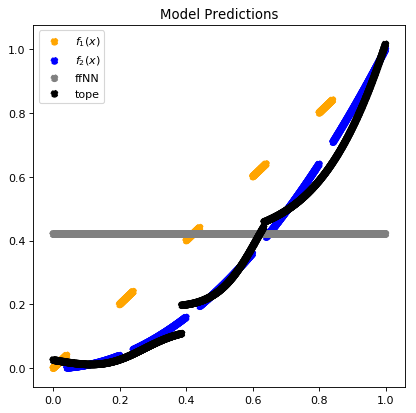

In [102]:
 # Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='orange',label=r'$f_1(x)$',linestyle='--')
plt.scatter(x_2,y_2,color='blue',label=r'$f_2(x)$',linestyle='--')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'gray',linestyle="--",  label='ffNN')
plt.scatter(x,Architope_prediction_y_train, color = 'black',linestyle="--",  label='tope')



# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO.pdf', format='pdf')

---
# Fin
---